<a href="https://colab.research.google.com/github/MCoutino/share_id/blob/master/relief_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TensorFlow Implementation of RELIEF 

## Imports and Packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# checking GPUs
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
# install pygsp toolbox
!pip install pygsp

# import pygsp toolbox
import pygsp as gsp

     |████████████████████████████████| 1.8MB 2.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/Colab\ Notebooks/*.py

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

import gf_utils as utils
import graphfilters_real as gf
import graphfilters_complex as gfc
import scheduler

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
'/content/drive/My Drive/Colab Notebooks/gf_utils.py'
'/content/drive/My Drive/Colab Notebooks/graphfilters_complex.py'
'/content/drive/My Drive/Colab Notebooks/graphfilters_real.py'
'/content/drive/My Drive/Colab Notebooks/scheduler.py'


In [4]:
import importlib
importlib.reload(utils)
importlib.reload(gf)
importlib.reload(gfc)
importlib.reload(scheduler)

<module 'scheduler' from '/content/drive/My Drive/Colab Notebooks/scheduler.py'>

## RELIEF Class

In [0]:
class Relief:

  def __init__(self, GSO, order, nlayers, gfType):
    self.GSO = GSO
    self.order = order
    self.nlayers = nlayers
    self.nnodes = GSO.shape[0]
    self.layers = {}
    self.layers_name = []
    self._compiler_params = {}
    self.loss_history = []
    self.gfType = gfType
    self.model = tf.keras.Sequential()
    self._start_model()
    self.set_model_compilation()
    

  def _create_layer(self, isFrozen=False, isFirst=False):
    """Creates a new GF layer and appended to the layers dict
    
    Returns:
    layerID (str) : layer identifier
    layer (GF) : newly created layer
    """

    GFLayer = gf.GFLayers[self.gfType]

    num_curr_layers = len(self.layers)
    layerID = 'gf_' + str(num_curr_layers)
    self.layers_name.append(layerID)
    
    layer = GFLayer(self.GSO, self.order)
    layer._name = layerID;

    self.layers[layerID] = layer
    self._init_layer(layerID,isFirst)
    if isFrozen:
      self._freeze_layer(layerID)

    return layerID, layer

  def _start_model(self):
    """Starts the model for training. Input and first GF are concatenated"""
    inputs = tf.keras.Input(shape=(self.nnodes,))
    layerID, layer = self._create_layer(isFirst=True)
    self.model.add(inputs)
    self.model.add(layer)

  def _init_C(self):
    """Returns the init vector for Classical GF, i.e., GF = I_mtx"""
    one_vector = np.array([[1]])
    zeros_matrix = np.zeros(shape=(1,self.order))
    return np.concatenate([one_vector,zeros_matrix],axis=1)

  def _init_NV(self):
    """Returns the init vector fo NV GF, i.e., GF = I_mtx"""
    one_vector = np.ones(shape=(self.nnodes,1))
    zeros_matrix = np.zeros(shape=(self.nnodes, self.order))
    return np.concatenate([one_vector, zeros_matrix],axis=1)
  
  def _init_CEV(self):
    """Returns the init vector for CEV GF, i.e., GF = I_mtx"""
    nnz_indices = self.GSO.indices
    nnz = nnz_indices.shape[0]
    zeros_matrix = np.zeros(shape=(nnz, self.order))
    mask_vector = (nnz_indices[:,0]  == nnz_indices[:,1]).numpy()
    one_vector = 1*mask_vector.reshape((nnz,1))

    return np.concatenate([one_vector, zeros_matrix], axis=1)

  def _init_layer(self, layerID, isFirst=False):
    """Initialize layer to default coefficients"""
    initWeights = {'C'  : [self._init_C()],
                   'NV' : [self._init_NV()],                   
                   'CEV': [self._init_CEV()]}
    if not isFirst:
      self.layers[layerID].set_weights(initWeights[self.gfType])

  def _freeze_layer(self, layerID):
    """Freezes layer <layerID>, making it untrainable"""
    self.layers[layerID].trainable = False

  def _make_layer_trainable(self, layerID):
    """Makes the layer <layerID> trainable"""
    self.layers[layerID].trainable = True

  def _fit_layer(self, x, y, layerID, batch_size = 32, epochs=1, verbose=0):
    """Fits the layer <layerID> to the data

    Returns:
    fitError (float) : Fitting error
    """
    self._make_layer_trainable(layerID)
    fitError = self._fit_model(x, y, batch_size, epochs, verbose)
    self._freeze_layer(layerID)

    return fitError

  def _refit_procedure(self, x, y, layerID_left, layerID_right, 
                       tol, max_it, batch_size = 32, epochs = 1, verbose =0):
    """Refits the layers <layerID_left> and <layerID_right> until 
    convergence or maximum number of iteration is reached
    
    Returns:
    fitError (float) : Fitting error
    """
    fitError = 1000
    num_it = 0
    while tol < fitError and num_it < max_it:
      num_it += 1

      self._fit_layer(x, y, layerID_left,
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = verbose)                       # provide lr?
      fitError = self._fit_layer(x, y, layerID_right, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 verbose = verbose)             # provide lr?

      if num_it%5 == 1:
        print('  Refit It: ' + str(num_it) + ', Loss: ' + str(fitError))

    return fitError

  def _fit_model(self, x, y, batch_size=32, epochs=1, verbose=0):
    """Base routine for fitting model"""

    self.model.compile(optimizer = self._compiler_params['opt'],
                       loss = self._compiler_params['loss'],
                       metrics = self._compiler_params['metrics'])
    
    history = self.model.fit(x, y,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = verbose)
    
    fit_loss = history.history['loss']
    self.loss_history.append(fit_loss)

    return fit_loss[-1]

  def fit_RELIEF(self, x, y, tol=1e-3, max_it=1e3,
                 batch_size = 32, epochs_refit = 10, 
                 epochs_first = 1, verbose = 0):
    """Iteratively fits the cascaded GFs using the data-driven 
    version of RELIEF
    
    Returns:
    fitError (float) : Fitting error
    """
    print('Batch size: ' + str(batch_size) + 
          ', Epochs: (' + str(epochs_first) + ', ' + str(epochs_refit) + ')' +
          ', Tol: ' + str(tol) + '; Max It: ' + str(max_it) + '\n')

    tf.keras.backend.clear_session()
    # fitting first layer
    layerID_right = self.layers_name[0]
    fitError = self._fit_layer(x, y, layerID_right,
                               batch_size = batch_size,
                               epochs = epochs_first,
                               verbose = verbose)

    print('Depth: 1, Loss: ' + str(fitError))

    while tol < fitError and len(self.layers) < self.nlayers:
      layerID_left, layer = self._create_layer()
      print(' ========================================================')
      print(' Adding layer: ' + layerID_left)
      print(' ========================================================')
      self.model.add(layer)
      fitError = self._refit_procedure(x, y, 
                                       layerID_left, 
                                       layerID_right, 
                                       tol, max_it,
                                       batch_size = batch_size,
                                       epochs = epochs_refit,
                                       verbose = verbose)
      print('Depth: ' + str(len(self.layers)), 'Loss: ' + str(fitError))

    return fitError 

  def fine_tune_cascaded(self, x, y, batch_size=32, epochs=100, verbose=1):
    """Fine tunes the structure by adjusting all coefficients by 
    full backpropagation"""

    for layerID in self.layers_name:
      self._make_layer_trainable(layerID)

    self._compiler_params['opt'] = tf.keras.optimizers.Adam(learning_rate=1e-6)

    fitError = self._fit_model(x, y, 
                               batch_size=batch_size, 
                               epochs=epochs, 
                               verbose=verbose)    
        
      
    return fitError

  def set_model_compilation(self, optimizer="adam", loss='mse', metrics=['mae']):
    """Define the default parameters for compiling the model"""
    self._compiler_params['opt'] = optimizer
    self._compiler_params['loss'] = loss
    self._compiler_params['metrics'] = metrics

## Extra helper functions

In [0]:
def cascaded_to_operator(cascaded):
  """From a (linear) cascaded model, it obtains the matrix operator"""
  I_mtx = tf.eye(cascaded.nnodes)
  H = cascaded.model.predict(I_mtx)
  return H

## Test for Relief

### Generate data

In [7]:
NUM_NODES = 64;
GSO, H, train_data = utils.gen_toy_data(NUM_NODES)
print('Number of samples: ' + str(train_data[0].shape[0]))
print('Number of Nodes: ' + str(train_data[0].shape[1]))

Number of samples: 131072
Number of Nodes: 64


### Create Cascade Structure

In [0]:
GFStruct = Relief(GSO, 2, 4, 'CEV')

In [9]:
GFStruct.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gf_0 (GraphFilterLayer)      (None, 64)                2106      
Total params: 2,106
Trainable params: 2,106
Non-trainable params: 0
_________________________________________________________________


### Fit Structure

In [17]:
x, y = train_data
GFStruct.fit_RELIEF(x, y, max_it=11,verbose = 1, batch_size=1000)

Batch size: 1000, Epochs: (1, 10), Tol: 0.001; Max It: 11

132/132 [==============================] - 1s 7ms/step - loss: 1.9991 - mae: 1.0100
Depth: 1, Loss: 1.9991096258163452
 Adding layer: gf_2
Epoch 1/10
132/132 [==============================] - 1s 8ms/step - loss: 0.7197 - mae: 0.5863
Epoch 2/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3202 - mae: 0.4022
Epoch 3/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2379 - mae: 0.3466
Epoch 4/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1909 - mae: 0.3108
Epoch 5/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1588 - mae: 0.2844
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1345 - mae: 0.2627
Epoch 7/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1172 - mae: 0.2462
Epoch 8/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1051 - mae: 0.2329
Epoch 9/10
132/132 [======================

0.0006938428850844502

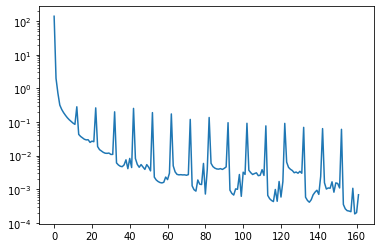

In [18]:
plt.plot(np.concatenate(GFStruct.loss_history))
plt.yscale('log')

In [0]:
GFStruct.loss_history

### Fine tunning

In [25]:
GFStruct.fine_tune_cascaded(x, y, batch_size=1000, epochs=100, verbose=1)
GFStruct.fine_tune_cascaded(x, y, batch_size=5000, epochs=50, verbose=1)
GFStruct.fine_tune_cascaded(x, y, batch_size=20000, epochs=20, verbose=1)
GFStruct.fine_tune_cascaded(x, y, batch_size=60000, epochs=2, verbose=1)

Epoch 1/2
3/3 [==============================] - 1s 170ms/step - loss: 7.0973e-05 - mae: 0.0058
Epoch 2/2
3/3 [==============================] - 0s 165ms/step - loss: 7.0859e-05 - mae: 0.0058


7.085854304023087e-05

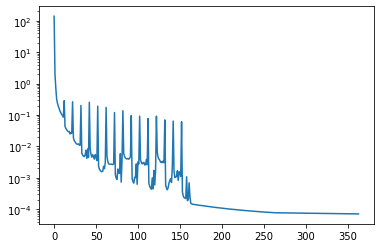

In [26]:
plt.plot(np.concatenate(GFStruct.loss_history))
plt.yscale('log')

In [27]:
Hest = cascaded_to_operator(GFStruct)
print(Hest[:5,:5])
print(H[:5,:5])

[[0.99916965 1.0003645  0.9997988  0.9998441  0.9991241 ]
 [1.0007527  1.0007396  0.99866134 1.0028278  1.0030215 ]
 [0.9988589  0.99993956 0.9977017  1.0053843  1.0012548 ]
 [1.0024431  0.99956733 0.99740493 1.0011684  0.99936295]
 [0.9987333  0.99814886 0.9988139  0.9984292  0.9994299 ]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [36]:
yest = GFStruct.model.predict(x)
print('Error:' + str(1/NUM_NODES * np.linalg.norm(yest[1,:] - y[1,:])))

Error:0.0009637450023681819
